In [11]:
import pandas as pd
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.neural_network import MLPClassifier
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

warnings.filterwarnings("ignore", category=ConvergenceWarning)


In [12]:
df = pd.read_csv('training.csv')
dftest = pd.read_csv('testing.csv')

In [13]:
target_column_name = 'class'
X = df.drop(target_column_name, axis=1)
y = df[target_column_name]

X_train = df.drop(target_column_name, axis=1)
y_train = df[target_column_name]

X_test = dftest.drop(target_column_name, axis= 1)
y_test = dftest['class']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

k=1, CV Mean Accuracy: 0.7431
k=2, CV Mean Accuracy: 0.7729
k=3, CV Mean Accuracy: 0.7679
k=4, CV Mean Accuracy: 0.7622
k=5, CV Mean Accuracy: 0.7918
k=6, CV Mean Accuracy: 0.7742
k=7, CV Mean Accuracy: 0.7742
k=8, CV Mean Accuracy: 0.7679
k=9, CV Mean Accuracy: 0.7918
k=10, CV Mean Accuracy: 0.7738
k=11, CV Mean Accuracy: 0.7799
k=12, CV Mean Accuracy: 0.7677
k=13, CV Mean Accuracy: 0.7619
k=14, CV Mean Accuracy: 0.7558
k=15, CV Mean Accuracy: 0.7383
k=16, CV Mean Accuracy: 0.7439
k=17, CV Mean Accuracy: 0.7501
k=18, CV Mean Accuracy: 0.7378
k=19, CV Mean Accuracy: 0.7201
k=20, CV Mean Accuracy: 0.7082

Best k based on cross-validation: 5 with CV accuracy: 0.7918


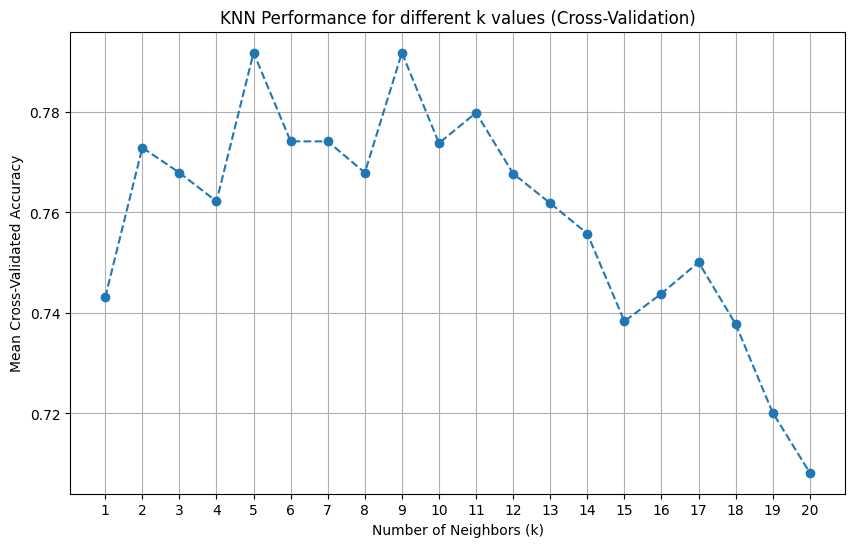

In [14]:
k_range = range(1, 21) # Test k values from 1 to 30 (adjust as needed)
cv_scores = [] # To store cross-validation scores for each k

for k_val in k_range:
    knn = KNeighborsClassifier(n_neighbors=k_val)
    # Perform 5-fold cross-validation (cv=5)
    # 'accuracy' is a common scoring metric. For imbalanced data, consider 'f1_macro', 'f1_weighted', etc.
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())
    print(f"k={k_val}, CV Mean Accuracy: {scores.mean():.4f}")

best_k_cv = k_range[np.argmax(cv_scores)]
print(f"\nBest k based on cross-validation: {best_k_cv} with CV accuracy: {max(cv_scores):.4f}")

plt.figure(figsize=(10, 6))
plt.plot(k_range, cv_scores, marker='o', linestyle='dashed')
plt.title('KNN Performance for different k values (Cross-Validation)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Cross-Validated Accuracy')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [15]:
k = 5
knn_model = KNeighborsClassifier(n_neighbors=k)

knn_model.fit(X_train_scaled, y_train)

y_pred = knn_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f"KNN Model Accuracy (k={k}): {accuracy:.4f}")

# Optional: Print more detailed evaluation metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


KNN Model Accuracy (k=5): 0.7239

Classification Report:
              precision    recall  f1-score   support

    asphalt        0.76      0.71      0.74        45
   building        0.86      0.67      0.75        97
        car        0.94      0.81      0.87        21
   concrete        0.72      0.82      0.76        93
      grass        0.65      0.71      0.68        83
       pool        0.79      0.79      0.79        14
     shadow        0.70      0.69      0.70        45
       soil        0.25      0.35      0.29        20
       tree        0.78      0.78      0.78        89

    accuracy                           0.72       507
   macro avg       0.72      0.70      0.71       507
weighted avg       0.74      0.72      0.73       507



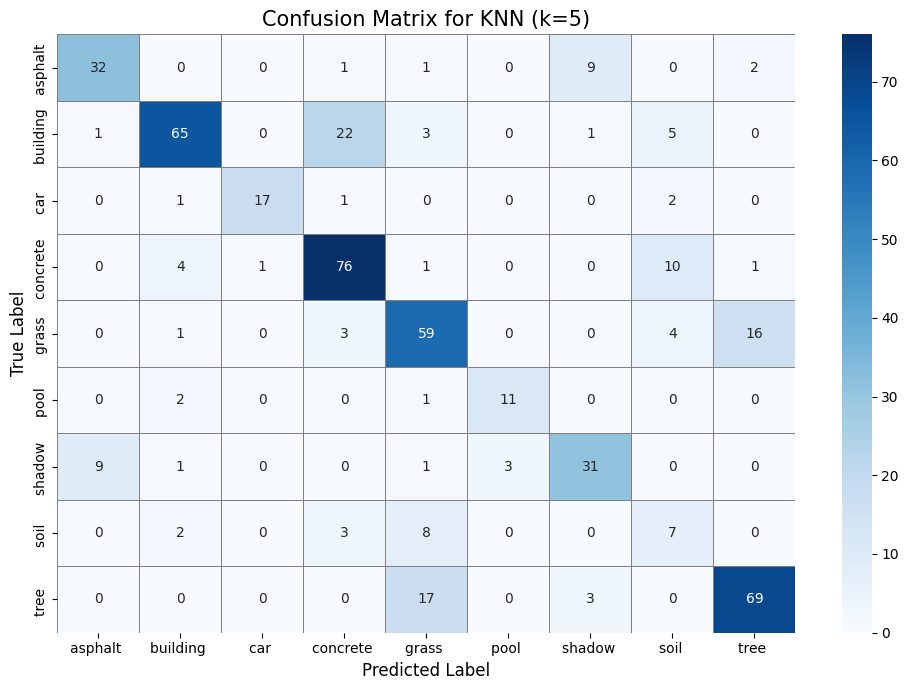

In [16]:
class_labels = np.unique(np.concatenate((y_test, y_pred)))

cm = confusion_matrix(y_test, y_pred, labels=class_labels)

cm_df = pd.DataFrame(cm,
                     index = class_labels,
                     columns = class_labels)

plt.figure(figsize=(10, 7)) # Adjust figure size
sns.heatmap(cm_df,
            annot=True,      # Display the numbers in each cell
            fmt='d',         # Format numbers as integers
            cmap='Blues',    # Colormap
            linewidths=.5,
            linecolor='gray',
            cbar=True)

plt.title(f'Confusion Matrix for KNN (k={best_k_cv})', fontsize=15)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
# plt.xticks(rotation=45, ha='right') # Uncomment if class names are long
# plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


--- Starting GridSearchCV to find best hyperparameters ---
Fitting 10 folds for each of 25 candidates, totalling 250 fits

--- Grid Search Results ---
Best parameters found: {'hidden_layer_sizes': (15,), 'max_iter': 200}
Highest 10-fold CV Accuracy: 0.7555

--- Creating and training the optimal model for plotting ---
Final test accuracy of the optimal model: 0.5917
Number of iterations run (due to early stopping): 56


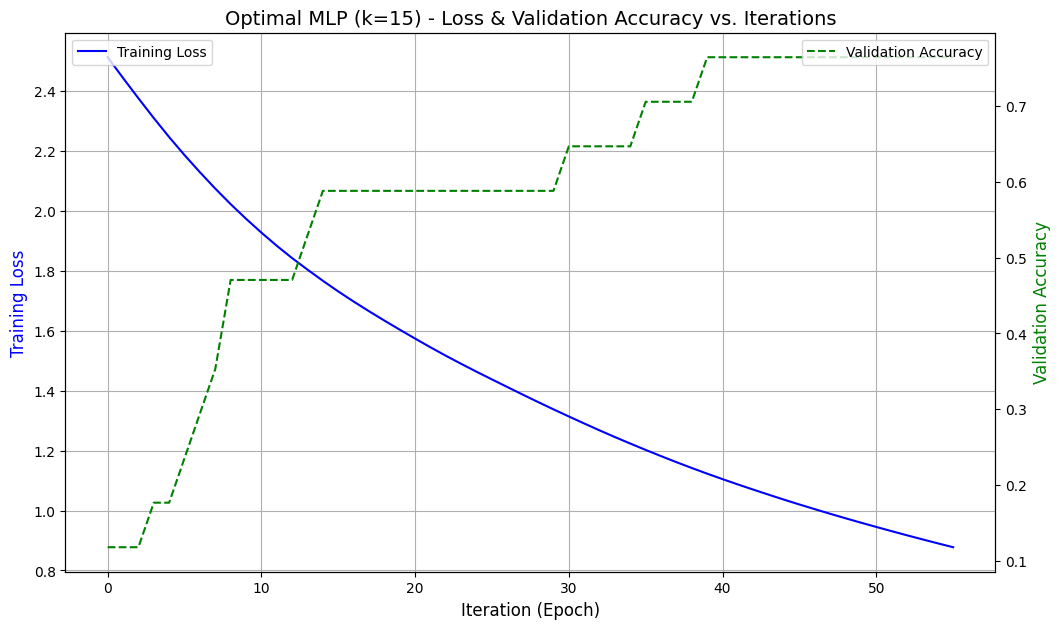

In [21]:
# Imports from your original script
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Assume X_train, y_train, X_test, y_test are pre-loaded and scaled
# For reproducibility, here's the setup from your file:
# df = pd.read_csv('training.csv')
# dftest = pd.read_csv('testing.csv')
# target_column_name = 'class'
# X_train = df.drop(target_column_name, axis=1)
# y_train = df[target_column_name]
# X_test = dftest.drop(target_column_name, axis=1)
# y_test = dftest[target_column_name]
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# --- 1. Hyperparameter Tuning with GridSearchCV ---

# Define the grid of hyperparameters to search
param_grid = {
    'hidden_layer_sizes': [(k,) for k in range(5, 26, 5)], # [5, 10, 15, 20, 25]
    'max_iter': [50, 100, 150, 200, 250]
}

# Setup and run GridSearchCV
# The base estimator for the grid search does not need early_stopping
grid_search = GridSearchCV(
    estimator=MLPClassifier(random_state=42),
    param_grid=param_grid,
    cv=10,
    scoring='accuracy',
    n_jobs=-1,  # Use all available CPU cores
    verbose=1
)

print("--- Starting GridSearchCV to find best hyperparameters ---")
grid_search.fit(X_train_scaled, y_train)

# --- 2. Report Grid Search Results ---
print("\n--- Grid Search Results ---")
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Highest 10-fold CV Accuracy: {grid_search.best_score_:.4f}")

# --- 3. Train and Plot the Optimal Model with Learning Curves ---

# Prepare integer labels required by MLPClassifier
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

print("\n--- Creating and training the optimal model for plotting ---")

# Create a new MLP model using the best parameters from the grid search.
# We unpack the 'best_params_' dictionary and enable 'early_stopping' to generate the learning curves.
optimal_mlp = MLPClassifier(
    **grid_search.best_params_,  # Unpacks {'hidden_layer_sizes': (best_k,), 'max_iter': best_iter}
    random_state=42,
    early_stopping=True,         # Enable early stopping for validation curves
    validation_fraction=0.1,
    n_iter_no_change=15          # A more reasonable value for early stopping
)

# Train the new model
optimal_mlp.fit(X_train_scaled, y_train_encoded)

# Report its performance as a final check
final_accuracy = optimal_mlp.score(X_test_scaled, y_test_encoded)
print(f"Final test accuracy of the optimal model: {final_accuracy:.4f}")
print(f"Number of iterations run (due to early stopping): {optimal_mlp.n_iter_}")

# --- 4. Generate the Plot ---
plt.figure(figsize=(12, 7))

# Plot Training Loss
plt.plot(optimal_mlp.loss_curve_, label='Training Loss', color='blue')
plt.title(f'Optimal MLP (k={optimal_mlp.hidden_layer_sizes[0]}) - Loss & Validation Accuracy vs. Iterations', fontsize=14)
plt.xlabel('Iteration (Epoch)', fontsize=12)
plt.ylabel('Training Loss', color='blue', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True)

# Create a second y-axis for the validation accuracy
ax2 = plt.gca().twinx()
ax2.plot(optimal_mlp.validation_scores_, label='Validation Accuracy', color='green', linestyle='--')
ax2.set_ylabel('Validation Accuracy', color='green', fontsize=12)
ax2.legend(loc='upper right')

plt.show()